In [91]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from sklearn.mixture import GaussianMixture
from scipy.optimize import dual_annealing,fmin_powell

from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread

In [3]:
def load_data(path_num,path_all = False):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    if path_all:
        path = path_all
    else:
        path = f'volume_data/patrice_10_29_2024_Timelapse/registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())

In [5]:
pics_without_line = np.array(tiffread('scan15/stack.tif')).astype(np.float32)

In [6]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30

In [7]:
mid = (np.argmax(np.sum(pics_without_line[0][:n//2],axis=1)) + pics_without_line[0].shape[0])//2
mid

783

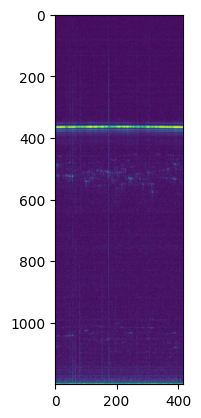

In [8]:
plt.imshow(pics_without_line[0])

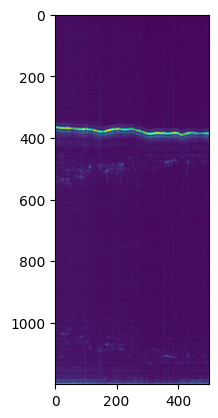

In [9]:
plt.imshow(pics_without_line.transpose(2,1,0)[100])

In [8]:
# pics_without_line = scp.median_filter(pics_without_line, size=3)

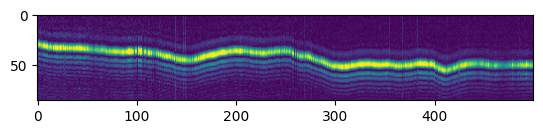

In [10]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

# Y-Motion

In [12]:
# def min_max(data1):
#     if np.all(data1 == data1[0]):
#         return data1
#     else:
#         data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
#         return data1

# def div3(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = phase(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
#     return data

# def phase(data,dis=False):
#     n = data.shape[0]//2
#     for i in range(data.shape[0]):
#         coords = phase_cross_correlation(data[n][UP:DOWN]
#                                         ,data[i][UP:DOWN]
#                                         ,normalization=None,upsample_factor=20)[0]
#         data[i] = scp.shift(data[i],shift = (coords[0],0),mode='constant',order=3)
#     return data

# def phase_join_chunks(first,second):
#     coords = phase_cross_correlation(first[-1][UP:DOWN]
#                                     ,second[0][UP:DOWN]
#                                     ,normalization=None,upsample_factor=20)[0]
#     for i in range(len(second)):
#         second[i] = scp.shift(second[i],shift = (coords[0],0),mode='constant',order=3)
#     return second


# def div3_reg_optz(data):
#     for i in tqdm(range(0,data.shape[0],3)):
#         data[i:i+3] = man_reg(data[i:i+3])

#     for i in tqdm(range(3,data.shape[0],3)):
#         data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
#     return data    

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(0,shif[0]))
#     warped = warp(x, tform,order=3)
#     return -nmi(y,warped)
#     # return mse(y,warped)

# def upsamp(data,n):
#     temp_data = data.copy()
#     temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
#     return temp_data

# def downsamp(data,n):
#     temp_data = data.copy()
#     temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
#     return temp_data

# def samp(data,n):
#     if n>1:
#         return upsamp(data,n)
#     if n<1:
#         return downsamp(data,np.abs(math.log(n,2)*2))
#     if n==1:
#         return data

# def man_reg(data):
#     n = data.shape[0]//2
#     # get_masks = cell_extract(data[1],4)
#     for i in range(data.shape[0]):
#         tform2 = AffineTransform(translation=(0,0))
#         if i!=n:
#             # best_mask = compare_masks(get_masks,data[n],data[i])
#             temp_i_data = data[i].copy()
#             for pyr in [2,2,2,4,4]:
#                 move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
#                         args = (samp((temp_i_data[220:320,100:200]),pyr)
#                                 ,samp((data[n][220:320,100:200]),pyr)))['x'])/pyr
#                 temp_transform = AffineTransform(translation=(0,move[0]))
#                 temp_i_data = warp(temp_i_data, temp_transform,order=3)
#                 tform2 = np.dot(tform2,temp_transform)
#                 # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
#             tform2 = AffineTransform(matrix = tform2)
#             data[i] = warp(data[i], tform2,order=3)
#             # print('done')
#     return data

# def man_join_chunks(first,second):
#     # get_masks = cell_extract(first[-1],4)
#     # best_mask = compare_masks(get_masks,first[-1],second[0])
#     tform3 = AffineTransform(translation=(0,0))
#     temp = second[0].copy()
#     for pyr in [2]*3:
#         move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
#                     args = (samp((temp[220:320,100:200]),pyr)
#                             ,samp((first[-1][220:320,100:200]),pyr)))['x'])/pyr
#         temp_transform = AffineTransform(translation=(0,move[0]))
#         temp = warp(temp, temp_transform,order=3)
#         tform3 = np.dot(tform3,temp_transform)
#     tform3 = AffineTransform(matrix = tform3)
#     for i in range(len(second)):
#         second[i] = warp(second[i], tform3,order=3)
#     return second

In [16]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

def find_mid(data):
    n = data.shape[1]
    mid = (np.argmax(np.sum(data[0][:n//2],axis=1)) + data[0].shape[0])//2
    return mid

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((data[i][UP:DOWN][:,:50])
                                        ,(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=2:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        for _ in range(5):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds=[(-2,2)],
                        args = (data[i][UP:DOWN][:,:50]
                                ,temp_manual[:,:50]))['x']
            temp_transform = AffineTransform(translation=(0,move[0]))
            temp_manual = warp(temp_manual, temp_transform,order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
        # if np.abs(np.array(temp_tform_manual)[1,2])<=2:
        # temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

    return transforms_all

In [17]:
original_data = pics_without_line

In [18]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)



warping: 100%|██████████| 500/500 [00:08<00:00, 60.40it/s]


286 446


warping: 100%|██████████| 500/500 [00:08<00:00, 59.71it/s]


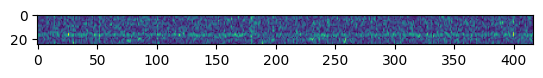

In [51]:
plt.imshow(original_data[50][975:1000])

In [27]:
y_corrected_data = original_data.copy()
UP,DOWN = 360,375
mir_UP,mir_DOWN = 0,1

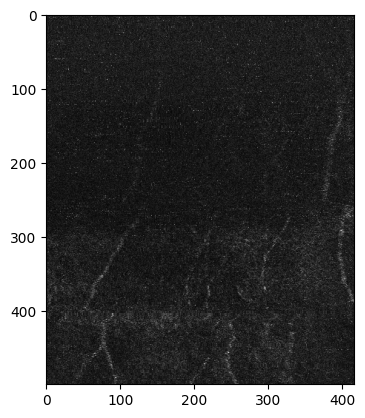

In [68]:
plt.imshow(np.mean(y_corrected_data[:,1131:1135,:],axis=1),cmap='gray')

In [96]:
temp_img = np.mean(y_corrected_data[:,1131:1135,:],axis=1).copy()

tp = fft2(temp_img).flatten()
tp[tp.shape[0]//2:] = 0
tp = np.where(np.abs(tp)>0.25,tp,0)
temp_img = ifft2(tp.reshape(temp_img.shape)).real

In [97]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=1)
    y = scp.shift(y, past_shift,order=1)

    warped_x_stat = scp.shift(x, -shif[0],order=1)
    warped_y_mov = scp.shift(y, shif[0],order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))

def denoise_signal(errs , rows = 10):
    kk = fft(errs)
    kk[rows:] = 0
    kk = abs(ifft(kk))
    return kk

In [ ]:
kk = []
for i in tqdm(range(temp_img.shape[0]-1)):
        st = denoise_signal(temp_img[i],rows=50)
        # mv = match_histograms(scp.median_filter(temp_img[i+1],size=3),st)
        mv = denoise_signal(temp_img[i+1],rows=50)
        rt = 0
        past_shift = 0
        # rt = phase_cross_correlation(st,mv,upsample_factor=10,disambiguate=True)[0][0]
        for _ in range(5):
                # move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-2,2)]),
                #         args = (st
                #                 ,mv
                #                 ,past_shift))['x']

                move = dual_annealing(func = shift_func,bounds = ([(-100,100)]),
                                        args = (st
                                                ,mv
                                                ,past_shift))['x'][0]
                past_shift += move
                rt += move
        kk.append(rt)

 99%|█████████▉| 496/499 [20:28<00:07,  2.59s/it]

In [95]:
dual_annealing(func = shift_func,bounds = ([(-100,100)]),
                args = (st
                        ,mv
                        ,past_shift))['x'][0]

1.5013802215013925

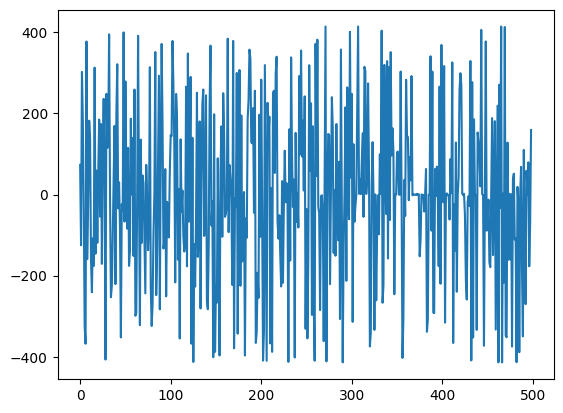

In [ ]:
plt.plot(kk)

In [87]:
temp_img = np.mean(y_corrected_data[:,1131:1135,:],axis=1).copy()
for i in range(len(kk)):
    temp_img[i+1] = scp.shift(temp_img[i+1],kk[i])

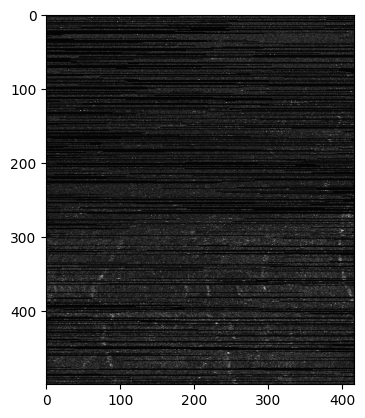

In [88]:
plt.imshow(temp_img,cmap='gray')

# OLD CODE

In [13]:
# pics_without_line[:,:mid] = div3(pics_without_line[:,:mid])

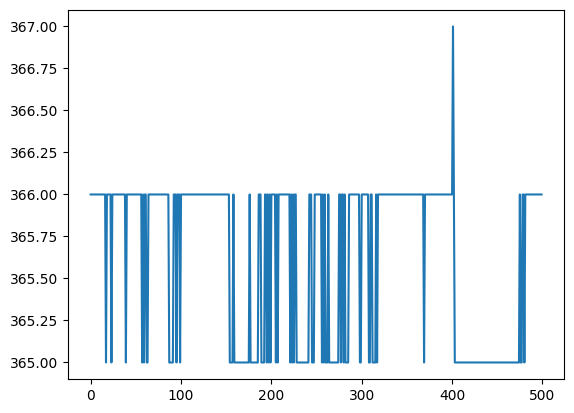

In [22]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

plt.plot(nn)

In [13]:
np.var(nn)

0.011856000000000002

In [14]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']


def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -ncc(y,warped)

In [15]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30

In [16]:
def ants_all_trans(data):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        # tff = AffineTransform(translation=(0,0))
        mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        # ar = np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1]))
        # ar[0,2],ar[1,2] = ar[1,2],ar[0,2]
        # tff = AffineTransform(matrix = ar)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all

In [917]:
# gg = pics_without_line.copy()

In [918]:
tr_all = ants_all_trans(pics_without_line)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

# tr_all = ants_all_trans(gg)
# for i in tqdm(range(gg.shape[0]),desc='warping'):
#     gg[i][:mid]  = warp(gg[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 70.10it/s]


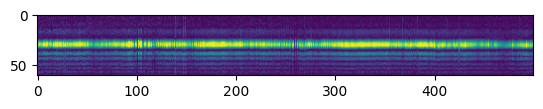

In [16]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

# X-motion

In [50]:
gg = pics_without_line.copy()

In [51]:
UP,DOWN

(336, 397)

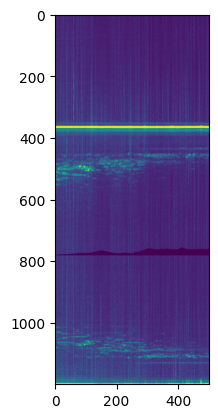

In [52]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [53]:
test = np.max(pics_without_line.transpose(2,1,0),axis=0)

In [54]:
bright_point = np.argmax(np.sum(test[:mid],axis=1))
dense_point = np.argmax(np.max(test[bright_point+30:bright_point+330],axis=1))+bright_point+30
bot_mirror = dense_point-bright_point-30
shp = test.shape[0]-30-bot_mirror

In [55]:
bright_point,dense_point

(368, 495)

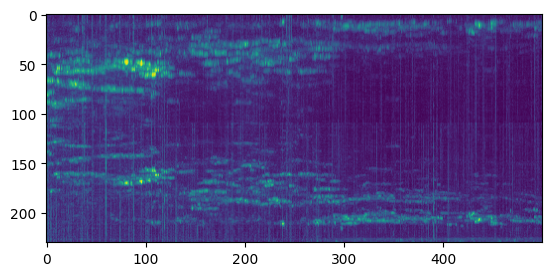

In [56]:
plt.imshow(test[np.r_[dense_point-50:dense_point+60,shp-60:shp+60]])

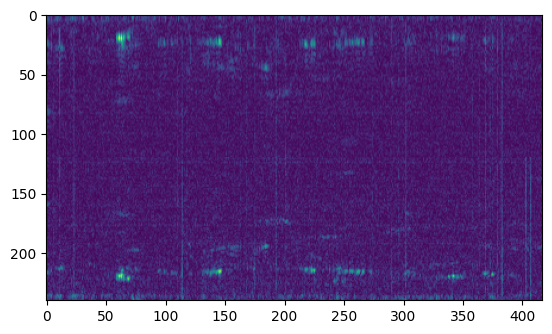

In [57]:
plt.imshow(gg[450][np.r_[dense_point-60:dense_point+60,shp-60:shp+60]])

In [58]:
mx_shp = shp-5 if shp+60>gg.shape[1] else shp+60
low_dp = bright_point+30 if dense_point-60<bright_point else dense_point-60

mx_shp,low_dp

(1133, 435)

In [59]:
# transforms_all = np.tile(np.eye(3),(500,1,1))

# # for i in tqdm(range(gg.shape[0]-1)):
# #     # tff = AffineTransform(translation=(0,0))
# #     mat = scipy.io.loadmat(ants_reg_mapping(gg[i][np.r_[220:300,1050:1120]],gg[i+1][np.r_[220:300,1050:1120]])[0])
# #     tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

# #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

# for i in tqdm(range(gg.shape[0]-1)):
#     # tff = AffineTransform(translation=(0,0))
#     mx_shp = shp-5 if shp+60>gg.shape[1] else shp+60
#     low_dp = bright_point+30 if dense_point-60<bright_point else dense_point-60

#     # mx_shp = gg.shape[1]-50
#     # low_dp = dense_point - 40

#     mat = scipy.io.loadmat(ants_reg_mapping(gg[i][np.r_[low_dp:dense_point+60,shp-60:mx_shp]],
#                                             gg[i+1][np.r_[low_dp:dense_point+60,shp-60:mx_shp]])[0])
#     tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
#     # ar = np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1]))
#     # # ar[0,2],ar[1,2] = ar[1,2],ar[0,2]
#     # tff = AffineTransform(matrix = ar)
#     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

In [60]:
def ants_man_reg(data):
    arr = np.tile(np.eye(3),(data.shape[0],1,1))
    mx_shp = shp-5 if shp+60>gg.shape[1] else shp+60
    low_dp = bright_point+30 if dense_point-60<bright_point else dense_point-60
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        if i!=n:
            mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[n][np.r_[low_dp:dense_point+60,shp-60:mx_shp]]),
                                                    min_max(data[i][np.r_[low_dp:dense_point+60,shp-60:mx_shp]]))[0])
            tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1][0],0))
            arr[i] = np.dot(arr[i],tff)
            # data[i] = warp(data[i], tff,order=3)
    return arr

def ants_man_join_chunks(first,second,tr_all):
    arr = tr_all.copy()
    mx_shp = shp-5 if shp+60>gg.shape[1] else shp+60
    low_dp = bright_point+30 if dense_point-60<bright_point else dense_point-60
    mat = scipy.io.loadmat(ants_reg_mapping(min_max(first[-1][np.r_[low_dp:dense_point+60,shp-60:mx_shp]]),
                                            min_max(second[0][np.r_[low_dp:dense_point+60,shp-60:mx_shp]]))[0])
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1][0],0))
    for i in range(len(second)):
        # second[i] = warp(second[i], tff,order=3)
        arr[i] = np.dot(arr[i],tff)
    return arr


def ants_div3_reg_optz(data):
    tr_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(0,data.shape[0],3)):
        tr_all[i:i+3] = ants_man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        tr_all[i:i+3] = ants_man_join_chunks(data[:i],data[i:i+3],tr_all[i:i+3])
    return data    

transform_all = ants_div3_reg_optz(gg)
# gg = ants_div3_reg_optz(gg)

100%|██████████| 166/166 [00:59<00:00,  2.77it/s]


In [61]:
transform_all

array([[[    0.     ,     0.     ,     0.     , ...,     0.     ,
             0.     ,     0.     ],
        [ 2565.4739 ,  3930.572  ,  2825.9512 , ...,  1826.4844 ,
          1903.9254 ,   761.7887 ],
        [ 3937.8296 ,  2105.3904 ,  1398.3302 , ...,  3465.597  ,
           622.4552 ,   259.27002],
        ...,
        [55944.     , 47952.     , 27173.     , ..., 61272.     ,
         27705.     , 33566.     ],
        [54346.     , 52747.     , 44755.     , ..., 65535.     ,
         48485.     , 48485.     ],
        [45288.     , 26107.     , 42091.     , ..., 31435.     ,
         34632.     , 22377.     ]],

       [[ 1572.     ,  2621.     ,  1572.     , ...,  2097.     ,
          4194.     ,  1048.     ],
        [ 1572.     ,  3145.     ,  3145.     , ...,  2097.     ,
          2097.     ,  2097.     ],
        [ 2097.     ,  2097.     ,  1572.     , ...,  1572.     ,
          1572.     ,  2621.     ],
        ...,
        [29359.     , 47709.     , 25689.     , ..., 4

In [127]:
# for i in tqdm(range(gg.shape[0])):
#     gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)

100%|██████████| 500/500 [00:09<00:00, 55.40it/s]


In [139]:
from skimage import feature
from skimage.transform import hough_line

In [31]:
temp_img = np.mean(gg.transpose(1,0,2)[1131:1133],axis=0)

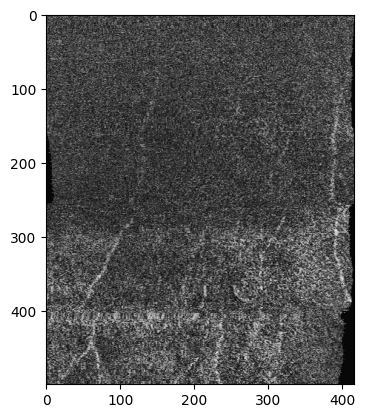

In [32]:
plt.imshow(equalize_adapthist(min_max(temp_img)),cmap='gray')

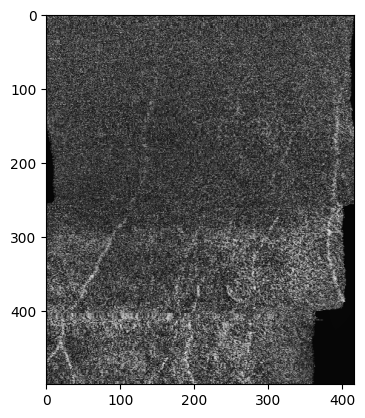

In [155]:
# plt.imshow(gg.transpose(2,1,0)[100][UP:DOWN])
plt.imshow(equalize_adapthist(min_max(temp_img)),cmap='gray')

In [694]:
# os.mkdir('volume_data/patrice_10_29_2024_Timelapse/registered/scan14')
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('volume_data/patrice_10_29_2024_Timelapse/test/'+f'frame_test{i}.PNG',(min_max(j)*(2**8)).astype(np.uint8))

500it [00:02, 196.29it/s]


# Inter Volume


In [6]:
data14 = load_data('scan14')
data15 = load_data('scan15')
data16 = load_data('scan16')

In [203]:
def fourier_domain_verification(image1, image2):
    # Frequency domain similarity
    fft1 = np.fft.fft2(image1)
    fft2 = np.fft.fft2(image2)

    return np.abs(np.sum(fft1 * np.conj(fft2)) / (np.linalg.norm(fft1) * np.linalg.norm(fft2)))

err_nmi = []
err_ncc = []
err_mse = []
err_fft = []
for i in tqdm(range(data14.shape[0])):
    # err_nmi.append(-nmi(data14[i],data15[350]))
    # err_ncc.append(-ncc(data14[i],data15[350]))
    # err_mse.append(mse(data14[i],data15[350]))
    err_fft.append(fourier_domain_verification(data14[i],data15[350]))



100%|██████████| 500/500 [00:23<00:00, 21.51it/s]


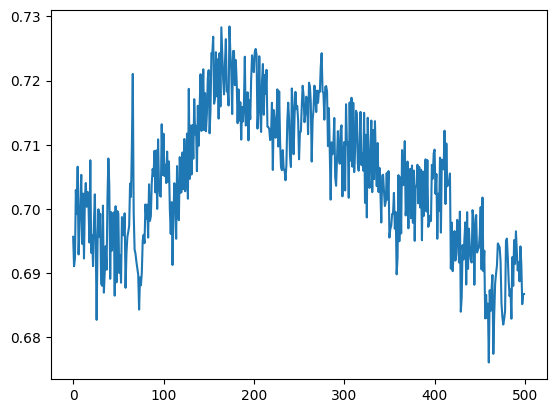

In [204]:
# plt.plot(err_nmi)
plt.plot(err_fft)
# plt.plot(err_ncc)
# plt.plot(err_mse)

In [209]:
image14 = np.mean(data14.transpose(1,0,2)[1131:1133],axis=0)
image15 = np.mean(data15.transpose(1,0,2)[1131:1133],axis=0)
image16 = np.mean(data16.transpose(1,0,2)[1131:1133],axis=0)

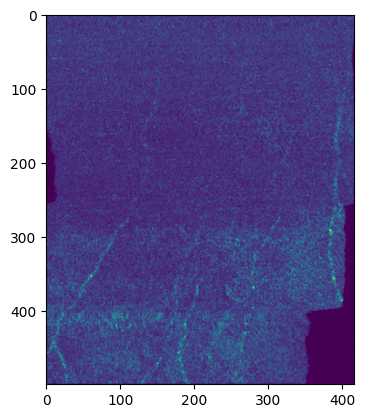

In [221]:
plt.imshow()

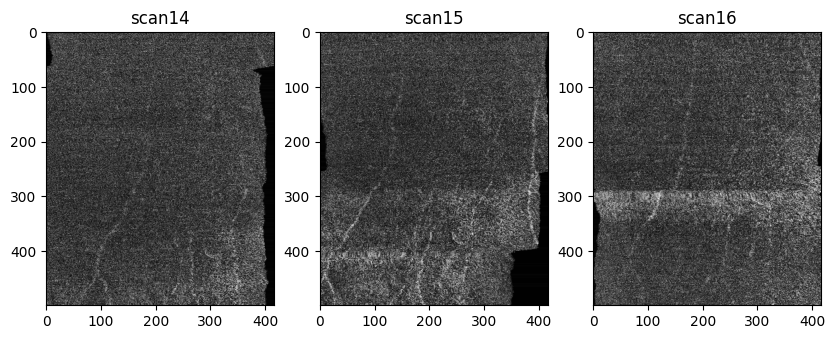

In [227]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('scan14')
ax1.imshow(equalize_adapthist(min_max(image14)),cmap='gray')

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('scan15')
ax2.imshow(equalize_adapthist(min_max(image15)),cmap='gray')

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('scan16')
ax3.imshow(equalize_adapthist(min_max(image16)),cmap='gray')

In [241]:
errs = []
for i in tqdm(range(data16.shape[0]-1)):
    errs.append(-nmi(min_max(data16[i][np.r_[290:400,850:925]]),min_max(data16[i+1][np.r_[290:400,850:925]])))


100%|██████████| 499/499 [00:02<00:00, 223.53it/s]


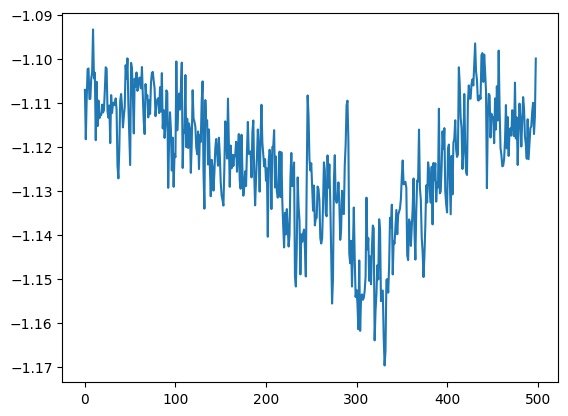

In [242]:
plt.plot(errs)

In [243]:
phase_cross_correlation(image14,image15,normalization=None,upsample_factor=20)[0]

array([101.35,  -1.  ], dtype=float32)

In [248]:
2-nmi(image14,image14)

2.220446049250313e-16

In [265]:
np.linalg.norm(image14)

7740.2095

In [263]:
np.correlate(image14.flatten(),image15.flatten())

array([47853360.], dtype=float32)

In [377]:
def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())

def mse_fun_tran(shif,x,y):
    # ccs = phase_cross_correlation(x,y,normalization=None,upsample_factor=20)[0]
    tform = AffineTransform(translation=(shif[0],shif[1]),rotation = (shif[2]))
    warped = warp(x, tform,order=3)
    return -ncc(y,warped)

test = warp(image15,AffineTransform(translation=(-101.35,1)),order=3)
ttt = minz(method='powell',fun = mse_fun_tran,x0 =(0,0,0),
                    args = (min_max(test),min_max(image14)))['x']

AffineTransform(translation=(ttt[0],ttt[1]),rotation=ttt[2])

<AffineTransform(matrix=
    [[ 0.99964144,  0.02677683, 10.51268601],
     [-0.02677683,  0.99964144,  7.20794729],
     [ 0.        ,  0.        ,  1.        ]]) at 0x1fb09e090>

In [378]:
ttt

array([10.51268601,  7.20794729, -0.02678003])

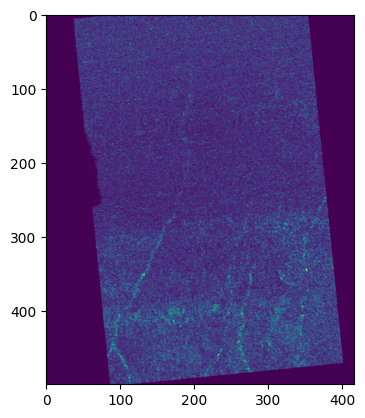

In [393]:
plt.imshow(warp(test,AffineTransform(translation=(65,-10),rotation=0.1),order=3))

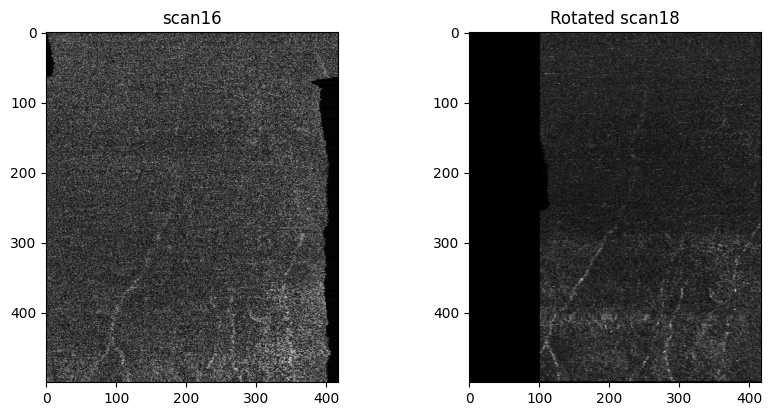

In [327]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('scan16')
ax1.imshow(equalize_adapthist(min_max(image14)),cmap='gray')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Rotated scan18')
ax2.imshow(min_max(warp(image15,AffineTransform(translation=(101.35,-1)).inverse)),cmap='gray')

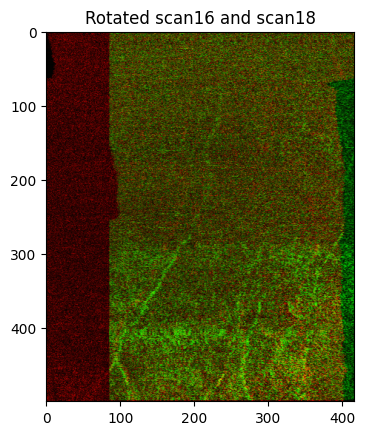

In [456]:
image14_color = np.zeros((image14.shape[0], image14.shape[1], 3), dtype=np.uint8)
image14_color[:, :, 0] = min_max(equalize_adapthist(min_max(image14)))*255 # Assign grayscale to the red channel

# # Color the second image in green channel
# image2_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
# image2_color[:, :, 1] = warp(image2,AffineTransform(translation=(-10,40))) # Assign grayscale to the green channel

image15_color = np.zeros((image15.shape[0], image15.shape[1], 3), dtype=np.uint8)
image15_color[:, :, 1] = min_max(equalize_adapthist(min_max(warp(image15,AffineTransform(translation=(85.35,-1)).inverse))))*255 # Assign grayscale to the green channel

# image2_unreg_color = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
# image2_unreg_color[:, :, 1] = image2  # Assign grayscale to the green channel
plt.title('Rotated scan16 and scan18')
plt.imshow(cv2.addWeighted(image14_color, 1, image15_color, 1, 1).astype(np.uint8))
# plt.imsave('volume_data/Hadiya_10_15_2024_Timelapse/registered/Rotated scan16 and scan18.PNG',cv2.addWeighted(image14_color, 1, image15_color, 1, 1).astype(np.uint8),dpi=500)